<a href="https://colab.research.google.com/github/christofkaelin/ca683-project-group-1/blob/main/CA683_Project_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA683 Project Group 1: Stock Market Price Trend Prediction
Authors: [Kevin Cogan](mailto:kevin.cogan3@mail.dcu.ie), [Paul Duhamel-Sebline](mailto:paul.duhamelsebline2@mail.dcu.ie), [Christof Kälin](mailto:christof.kalin2@mail.dcu.ie) and [Gonzalo López Gil](gonzalo.lopezgil2@mail.dcu.ie)


## Week 1: Project initialization
In this week, we built our group, agreed upon a dataset, formulated the goal and loaded the data.

### Dataset

Since Paul and Gonzalo are doing their [practicum](https://gitlab.computing.dcu.ie/lopezgg2/2024-mcm-lopezgg2-duhamep2) together on the prediction of stock market price trends, we decided to go with this topic.

Therefore, we went with a dataset found on Kaggle that has historical data about stocks from January 2000 until today: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating

### Goal

@Gonazlo @Paul:
Stipulate the questions you want to answer. The dataset must be approved beforehand and marks will be awarded based on difficulty and imagination of the solution.

### Loading the data

In [ ]:
# Download the dataset to the Colab environment
!wget https://student.computing.dcu.ie/~kalinc2/ca683/World-Stock-Prices-Dataset.csv

--2024-01-25 12:15:02--  https://student.computing.dcu.ie/~kalinc2/ca683/World-Stock-Prices-Dataset.csv
Resolving student.computing.dcu.ie (student.computing.dcu.ie)... 136.206.218.15
Connecting to student.computing.dcu.ie (student.computing.dcu.ie)|136.206.218.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41042247 (39M) [text/csv]
Saving to: ‘World-Stock-Prices-Dataset.csv’

World-Stock-Prices- 100%[===================>]  39.14M  17.6MB/s    in 2.2s    

2024-01-25 12:15:05 (17.6 MB/s) - ‘World-Stock-Prices-Dataset.csv’ saved [41042247/41042247]



In [ ]:
# Import the pandas and read the CSV file
import pandas as pd
df = pd.read_csv("World-Stock-Prices-Dataset.csv")

## Week 2: Regression

In [ ]:
# Filter by Apple stocks (AAPL), select the columns "Date" and "Close", sort by ascending by date and reset the index
df_aapl = df[df['Ticker'] == 'AAPL'][['Date', 'Close']].sort_values(by='Date').reset_index(drop=True)
df_aapl.head()

,Date,Close
0,2000-01-03 00:00:00-05:00,0.848323
1,2000-01-04 00:00:00-05:00,0.776801
2,2000-01-05 00:00:00-05:00,0.788168
3,2000-01-06 00:00:00-05:00,0.719961
4,2000-01-07 00:00:00-05:00,0.754065


<Axes: xlabel='Date'>

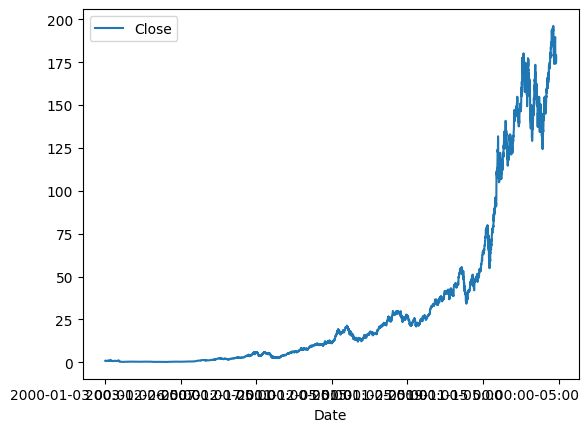

In [ ]:
df_aapl.plot.line(x='Date', y='Close')